This is a model for evaluating adsorption heat pump cycles, given a function for calculating isotherms of the adsorbant. The model is somewhat based on https://sci-hub.se/https://doi.org/10.1016/S1359-4311(98)00013-1 , but with some big variation.

The system imagines the adsorbant material loaded into a barrel of a piston, filled with CO2. The piston "moves" to change the pressure of the chamber, causing the amount of CO2 sorbed into the adsorbant to change.

The model calculates the adiabatic compression, isothermal compression, adiabatic expansion, and isothermal expansion processes, tracking work and heat flow for each step.

Then, the model calculates a COP based on those results.

This model is set up with parameters for MAXSORB 3, but changing the isotherm should allow for evaluation of different materials.

The model uses CoolProp to treat CO2 as a real gas.

The model sets the number of moles of gas in the system (NGMAX) as the number of moles sorbed at high temperature / high pressure, plus the number of moles of gas in the volume of the sorbent at high temperature / high pressure (assuming there is no adsorbant actually there).

For stages, the material splits the temperature window in 2, and runs cycles at each temperature. Then, it re-scales the work and heat so that the heat of the interface between the stages is equal. This isn't totally accurate, but should be good enough

Key variables that may be worth changing:


*   Step size (h)
*   Low pressure (lowP)
*   High pressure options (P_array_high)
*   Number of stages (num_stages)
*   Cold temperature (T_cold)
*   Hot temperature (T_hot)
*   NGMax Multiplier - excess, parasitic free gas in the system
* Amount of binder dead mass in the system (binderMass)

Known Issues:


*   There is a tool for dynamically calculating enthalpy, since it will change slightly with temperature and pressure. However, this screws up all the other integration as it adds more T and P dependence, so it is not implemented.
*   There is one first law error introduced by using big step sizes, which goes away by shrinking the integration step. This error is small and safe to ignore.
*   I believe there is another first law error somewhere else in the code that is giving a small deviation. If it is an error in heat, it isn't a problem at all, as it is small. If it is an error in the work calculation, it could slightly affect the results.
*   There are a few other minor buggy things (you might see a weird spike in COP for the cold side below the pressure needed to get the adiabatic jump, this is because the work crosses 0 and you end up dividing by a tiny number)



To do:


*   Change COP to Carnot efficiency (?)
*   Update to allow for dynamic enthalpy changes
*   Fix more bugs and dumb problems
*   Replace the RK methods with the scipi quad function (?)












In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


<ipython-input-2-1c26b711093f>:229: RuntimeWarning: invalid value encountered in scalar divide
  n_chargingChamber_post[i] = (run_post[i-1,1] - p_vac[i]) * v_charge[i-1] / (run_post[i-1,2] *8.314*10**6 * T_run_K)


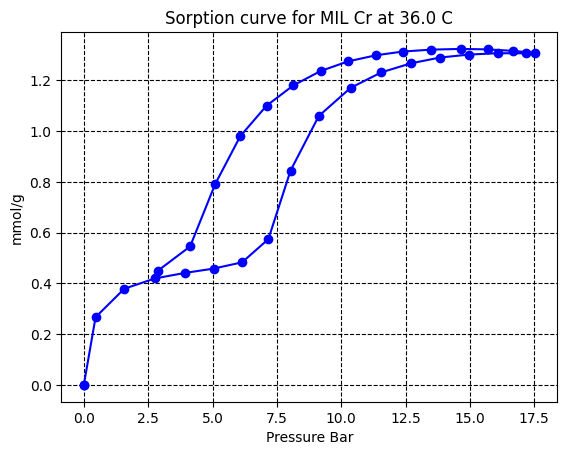

[  0.           0.           6.62740597  22.78576435  40.0682407
  56.88310957  73.12396926  89.18072601 103.99266286 116.51186304
 132.44011774 150.34140398 167.65568084 184.38794839 200.75221006
 217.10347152 233.20172893 249.34498706 254.1130633  241.82586683
 227.96664522 212.47839756 195.8391315  179.76387445 164.64363268
 148.92238129 133.43613366 118.0788881  102.95464626  88.16320974
  74.01838356  59.89585774  41.7879682 ]
[0.         0.         0.26694508 0.37884738 0.41955271 0.44114424
 0.45831976 0.48297965 0.57434375 0.84469375 1.0597218  1.17027308
 1.23141211 1.26718964 1.28982038 1.30160505 1.30688014 1.30649884
 1.30806272 1.31613513 1.32185588 1.32379196 1.32105259 1.31346976
 1.29872693 1.27473267 1.23670296 1.18007426 1.09998327 0.97988986
 0.79119833 0.54560793 0.45008754]
The density of the sample is -3.0774404991390694 g/cm^3
The code has finished running


In [ ]:
from re import M
#%reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import statistics as st




# See PyCharm help at https://www.jetbrains.com/help/pycharm/

#Things the user must input
#This script can only find curves for one temp, so need to change here for more runs (basically one sheet)
mass_sample = 0.6695 #g
T_run_C = 36.0 #C
name_compound = "MIL Cr"
working_gas = "CO2" #This has to match the same syntax as the report.csv
T_run_K = T_run_C + 273.15 #K

#This is to select for the correct viral coefficient for the working gas
gas=0;
if working_gas == "CO2":
    gas=1
elif working_gas == "C3H8":
    gas=0

#Loading the data
data = pd.read_csv('/content/gdrive/Shareddrives/Pascal/Technology/Chemistry/Jinyoung/archive/Sharon/Experimental Documentation/Sorption/Raw Data/250131-1542-250131_mil53cr_24_12_36c_co2_0p3169g/data.csv')

#Loading the report, need to get rid of all commas inside the csv file for this version
report = pd.read_csv('/content/gdrive/Shareddrives/Pascal/Technology/Chemistry/Jinyoung/archive/Sharon/Experimental Documentation/Sorption/Raw Data/250131-1542-250131_mil53cr_24_12_36c_co2_0p3169g/MOFReport.csv', quotechar="'", encoding='latin-1')

#Parameters that I keep between experiments

#Density sheet
#Chamber volume
v_c_small = 9.141 #cm^3, I think there is a typo in the Excel sheet
#v_c_small = 8.965631287988177 #cm^3 -> from new calibration calculation 241223
v_c_large = 9.446 #cm^3, not used in density calculation but later

#Virial Constants for N2
a_N2 = 185.4 #cm^3/mol
b_N2 = 141.8 #cm^3/mol
c_N2 = 88.7 #K

#Gas Constant
R = 1205.9 #psi*cm^3/K*mol

#Temperature
T_C_N2 = 24 #C
T_K_N2 = T_C_N2+273.15 #K

#Second Virial Coefficient
B_N2 = a_N2 - b_N2 * np.exp(c_N2/T_K_N2) #cm^3/mol


#Now calculating the density sheet
N2_initial = np.zeros(3)
N2_final = np.zeros(3)
vacuum_N2_start = np.zeros(3)
vacuum_N2_raw = np.zeros(3)
vacuum_N2_zeroed_initial = np.zeros(3)
vacuum_N2_zeroed_final = np.zeros(3)
PRT_initial = np.zeros(3)
PRT_final = np.zeros(3)
M_vol_initial = np.zeros(3)
M_vol_final = np.zeros(3)
M_vol_ratio = np.zeros(3)
gas_vol = np.zeros(3)
gas_vol_real = 0; #cm^3
v_sample_holder = 3.59281546300944 #cm^3, this comes from calibration experiments
#v_sample_holder = 3.4796267808604346 #cm^3, from new calibration 241223



#This is the key labels we need to search for
s1 = 'Sequence 1: N2 at 24.0 Â°C'
s2 = 'Sequence 2: N2 at 24.0 Â°C'
s3 = 'Sequence 3: N2 at 24.0 Â°C'

#This will look through the report labels
for i in range(len(report)):
    #These are finding the initial and final N2 pressures
    if report.iloc[i,0]==s1:
        N2_initial[0] = report.iloc[i+8,1]
        N2_final[0] = report.iloc[i+10,1]
        vacuum_N2_start[0] = (report.iloc[i+3,1])
    elif report.iloc[i,0]==s2:
        N2_initial[1] = report.iloc[i+8,1]
        N2_final[1] = report.iloc[i+10,1]
        vacuum_N2_start[1] = (report.iloc[i + 3, 1])
    elif report.iloc[i,0]==s3:
        N2_initial[2] = report.iloc[i+8,1]
        N2_final[2] = report.iloc[i+10,1]
        vacuum_N2_start[2] = (report.iloc[i + 3, 1])

vacuum_N2_start = np.floor(vacuum_N2_start)

#Here is finding the raw vacuum data
for i in range(len(vacuum_N2_raw)):
    #This is the orange vacuum pressures for zeroing
    vacuum_N2_start[i] = int(vacuum_N2_start[i])
    vacuum_N2_raw[i] = np.mean(data.iloc[(int(vacuum_N2_start[i])-100):int(vacuum_N2_start[i]),2])

    #This is doing the zeroing
    vacuum_N2_zeroed_initial[i] = N2_initial[i] - vacuum_N2_raw[i]
    vacuum_N2_zeroed_final[i] = N2_final[i] - vacuum_N2_raw[i]

    #This is doing some P/RT calculations
    PRT_initial[i] = vacuum_N2_zeroed_initial[i]/(R*T_K_N2)
    PRT_final[i] = vacuum_N2_zeroed_final[i] / (R * T_K_N2)

    #This is doing molar volume calculations
    M_vol_initial[i] = (1 + np.sqrt(1 - 4 * PRT_initial[i] * (-B_N2))) / (2 * PRT_initial[i])
    M_vol_final[i] = (1 + np.sqrt(1 - 4 * PRT_final[i] * (-B_N2))) / (2 * PRT_final[i])
    M_vol_ratio[i] = M_vol_final[i] / M_vol_initial[i] - 1

    #This is calculating sample volume
    gas_vol[i] = v_c_small * M_vol_ratio[i]
#THIS MIGHT BE AN ERROR, SEEMS TO BE OFF BY 0.001 CM^3


gas_vol_real = np.mean(gas_vol)
v_sample = v_sample_holder - gas_vol_real #cm^3
density_sample = mass_sample / v_sample #g/cm^3




#Now calculating the sorption and desorption curve at a specific temp
[r,c]=report.shape

#This is for finding background vacuum pressure
#This is the key labels we need to search for
s5 = 'Sequence 7: ' + working_gas + ' at ' + str(T_run_C) +' Â°C'

#These are parameters
run_start = 0 #This is when the CO2 or C3H8 gets injected
run_raw_background_high_P = np.zeros(300)
run_raw_background_low_P = np.zeros(300)

#These are the things the person will copy over
run_initial = np.zeros((c+1)*3).reshape(c+1,3)
run_final = np.zeros((c+1)*3).reshape(c+1,3)
run_post = np.zeros((c+1)*3).reshape(c+1,3)
v_charge = np.zeros(c+1)
p_vac = np.zeros(c+1)
n_tot = np.zeros(c+1)

#This will look through the report labels
for i in range(len(report)):
    #These are finding the raw background vacuum pressures
    if report.iloc[i,0]==s5:
        run_start = np.floor(float((report.iloc[i+3,1])))
        run_raw_background_high_P = data.iloc[(int(run_start) - 300):int(run_start), 1]
        run_raw_background_low_P = data.iloc[(int(run_start) - 300):int(run_start), 2]

# THIS IS PULLING THE DATA WEIRDLY, COULD BE AN ERROR
        run_initial[1:-1,0] = report.iloc[i + 8, 1:c]
        run_final[1:-1,0] = report.iloc[i + 9, 1:c]
        run_post[1:-1,0] = report.iloc[i + 10, 1:c+1]
        v_charge[1:-1] = report.iloc[i + 13, 1:c]

#This finds the backgound pressure in vacuum before the run
run_vacuum_background_low = np.mean(run_raw_background_low_P)
run_vacuum_background_high = np.mean(run_raw_background_high_P)


#Need to set the first part of run_post
#run_post[0,0] = run_vacuum_background_low
#run_post[1,0] = run_vacuum_background_low * 6894.76
#run_post[2,0] = 1

#Parameters for temperature sheets
v_v = 0.02252 #cm^3 VALVE VOLUME

B_star=np.zeros(2)
#This is B_Star (second virial coefficient (swapped to m^3/mol) / RT) for propane. Source is "Virial coefficients of pure gasses landolt bornstein numerical data... ISBN 3-540-43345-7 Springer-Verlag Berlin Heidelberg New York"
B_star[0] = (1.0971 * 10**2 - 8.4673 * 10**4 / T_run_K - 8.1215 * 10**6 / (T_run_K**2) - 3.482 * 10**9 / (T_run_K**3)) / (8.314 * 10**6 * T_run_K)
#This is B_Star for CO2
B_star[1] = (5.74*10 - 3.8829 * 10**4 / T_run_K + 4.2899 * 10**5 / (T_run_K**2) - 1.4661 * 10**9 / (T_run_K**3)) / (8.314 * 10**6 * T_run_K)

#This is finding the right charge volume and pressure vac
for i in range(len(v_charge)):
    if v_charge[i] == v_c_small:
        p_vac[i] = run_vacuum_background_low * 6894.76 #converting to Pa from PSI
    elif v_charge[i] == v_c_large:
        p_vac[i] = run_vacuum_background_high * 6894.76


#This adds the P_post initial conditions
run_post[0] = run_vacuum_background_low

#Now we have to calculate the other terms in the pressure stuff
for i in range(len(run_initial)):
    run_initial[i,1] = run_initial[i,0] * 6894.76
    run_initial[i,2] = 1 + B_star[gas] * (run_initial[i,1]-p_vac[i])
    #This is the compressibility factor for correcting the non-ideality of the gas.
    #For an ideal gas, Z = 1 (Bstar = 0), or Z = PV/RT. In real systems, PV/RT = Z = 1 + B*P + C*P^2... etc.
    #Here, we correct the pressure with the vacuum background, then multiply by the virial coefficient correction

for i in range(len(run_final)):
    run_final[i,1] = run_final[i,0] * 6894.76
    run_final[i,2] = 1 + B_star[gas] * (run_final[i,1]-p_vac[i])

for i in range(len(run_post)-1):
    run_post[i,1] = run_post[i,0] * 6894.76
    if i == 0:
        run_post[i,2] = 1
    else:
        run_post[i,2] = 1 + B_star[gas] * (run_post[i,1]-p_vac[i+1])
    #Due to some insanity with the spreadsheet, the "post" data is offset by one

#Now find n_tot
#This calculates the total moles absorbed - note it is off from the Excel sheet since v_c was wrong in the sheet I think

n_chargingChamber = np.zeros(c)
for i in range(len(n_tot)-1):
    n_chargingChamber[i] = (run_initial[i,1]-p_vac[i]) * v_charge[i] / (run_initial[i,2] * 8.314 * 10**6 * T_run_K)

n_bothChambers = np.zeros(c)
for i in range(len(n_tot)-1):
    n_bothChambers[i] = (run_final[i-1,1] - p_vac[i]) * (v_charge[i-1] + v_sample_holder + v_v - v_sample) / (run_final[i-1,2] * 8.314 * 10**6 * T_run_K)

n_chargingChamber_post = np.zeros(c)
for i in range(len(n_tot)-1):
    n_chargingChamber_post[i] = (run_post[i-1,1] - p_vac[i]) * v_charge[i-1] / (run_post[i-1,2] *8.314*10**6 * T_run_K)

n_bothChambers_post = np.zeros(c)
for i in range(len(n_tot)-1):
    n_bothChambers_post[i] = (run_final[i,1] - p_vac[i]) * (v_charge[i] + v_sample_holder + v_v - v_sample) / (run_final[i,2] * 8.314*10**6 * T_run_K)


    #The N_Tot calculation is a mass balance.
    #The equation is: ns_Tot(i) = ns_Tot(i-1) + n_chargingChamber + n_BothChambers(i-1) - n_ChargingChamber(PostPressure)(i-1) - n_BothChambers(i)
    #ns_Tot(i-1) is the number of mol already sorbed in the sample
    #n_chargingChamber is the corrected charging pressure * volume of charging chamber / ZRT
    #n_BothChambers(i-1) is corrected equilibrium pressure from last datapoint * (Vcharging chamber + VSampleChamber + ValveVolume - Sample volume) / ZRT
    #n_charging chmaber (post pressure) is postpressure from last datapoint times Vcharging chamber
    #n_bothchambers(i) is this datapoint's equilibrium pressure times all the volumes

    # To walk through the experiment:
    #There's a charging chamber, and a sample chamber. The charging chamber is brought to a target pressure, the valve opened, and the two chambers equilibrated
    #Gas is stored in the sample (sorbed), and in the atmosphere in the two chambers.
    #The spreadsheet is completely insane and difficult to read, but it is looking at all these small other volumes to make sure we're accounting for everything.
    #To me, I still cannot follow where everything is - various terms are offset in odd ways, so "i" doesn't line up with each datapoint correctly.

    #If I am following, one "delta" is from n_charging chamber and n_charging chamber post pressure. This says "this difference is the number of moles of gas we are introducing into the system when we change the charge pressure"
    #The other "delta" is the change in the two equilibrium pressures for the whole chamber. Pressure in the whole chamber means moles of gas that are NOT sorbed in the sample
    #So you could think of it as N_sample[i] + N_chamber[i] = N_sample[i-1] + N_chamber[i-1] + DeltaN_Added -> Then, just pop everything in terms of PV/ZRTs, and we're in businesss

for i in range(len(n_tot)-1):
    if i == 0:
        n_tot[i] = 0
    else:
        n_tot[i+1] = n_tot[i] + n_chargingChamber[i] + n_bothChambers[i] - n_chargingChamber_post[i] - n_bothChambers_post[i]

#Calculate the rest of the sheet columns
p_bar = np.zeros(c)
for i in range(len(p_bar)-1):
    p_bar[i+1] = run_final[i,1] / 100000

C_STP = n_tot * 22.4 *1000 / v_sample #cm^3 (STP) /cm^3
C_mmol = n_tot[0:-1] * 1000 / mass_sample


#Now plotting the data
plt.plot(p_bar, C_mmol,'bo-')
plt.xlabel("Pressure Bar")
plt.ylabel("mmol/g")
plt.title("Sorption curve for " + str(name_compound) + " at " + str(T_run_C) + " C")
plt.grid(visible=True, which='major', color='k', linestyle='--')
plt.grid(visible=True, which='minor', color='k', linestyle='--')
plt.show()

print(p_bar*14.504)
print(C_mmol)

print("The density of the sample is " + str(density_sample) + " g/cm^3")
print("The code has finished running")


In [ ]:
P_hot = p_bar
V_hot = C_mmol

In [ ]:
P_cold = p_bar
V_cold = C_mmol

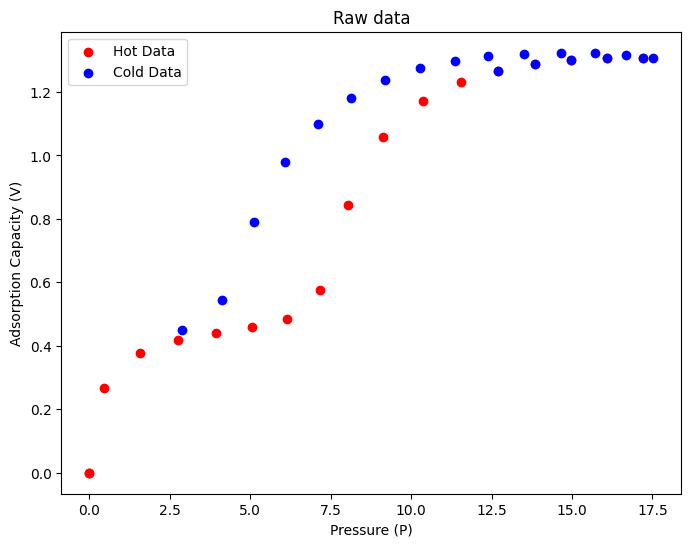

[ 0.          0.          0.45693643  1.57099865  2.76256486  3.92189117
  5.04164157  6.1486987   7.16992987  8.03308488  9.13128225 10.36551324
 11.55927198 12.71290323 13.84116175 14.96852396 16.07844242 17.19146353]
[0.         0.         0.26694508 0.37884738 0.41955271 0.44114424
 0.45831976 0.48297965 0.57434375 0.84469375 1.0597218  1.17027308
 1.23141211 1.26718964 1.28982038 1.30160505 1.30688014 1.30649884]
[12.71290323 13.84116175 14.96852396 16.07844242 17.19146353 17.52020569
 16.67304653 15.71750174 14.64964131 13.50242219 12.39408952 11.35160181
 10.26767659  9.19995406  8.14112577  7.09836226  6.07854452  5.1033083
  4.12960961  2.88113405]
[1.26718964 1.28982038 1.30160505 1.30688014 1.30649884 1.30806272
 1.31613513 1.32185588 1.32379196 1.32105259 1.31346976 1.29872693
 1.27473267 1.23670296 1.18007426 1.09998327 0.97988986 0.79119833
 0.54560793 0.45008754]


In [ ]:
# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(P_hot[0:18], V_hot[0:18], label="Hot Data", color="red")
plt.scatter(P_cold[13:], V_cold[13:], label="Cold Data", color="blue")
plt.xlabel("Pressure (P)")
plt.ylabel("Adsorption Capacity (V)")
plt.legend()
plt.title("Raw data")
plt.show()

print(P_hot[0:18])
print(V_hot[0:18])
print(P_cold[13:])
print(V_cold[13:])

<ipython-input-6-d2d3144381c4>:49: OptimizeWarning: Covariance of the parameters could not be estimated
  params_vh1, _ = curve_fit(vant_hoff, Temps, K1_values, p0=[K1_hot, -5000],maxfev=10000)
<ipython-input-6-d2d3144381c4>:50: OptimizeWarning: Covariance of the parameters could not be estimated
  params_vh2, _ = curve_fit(vant_hoff, Temps, K2_values, p0=[K2_hot, -5000],maxfev=10000)


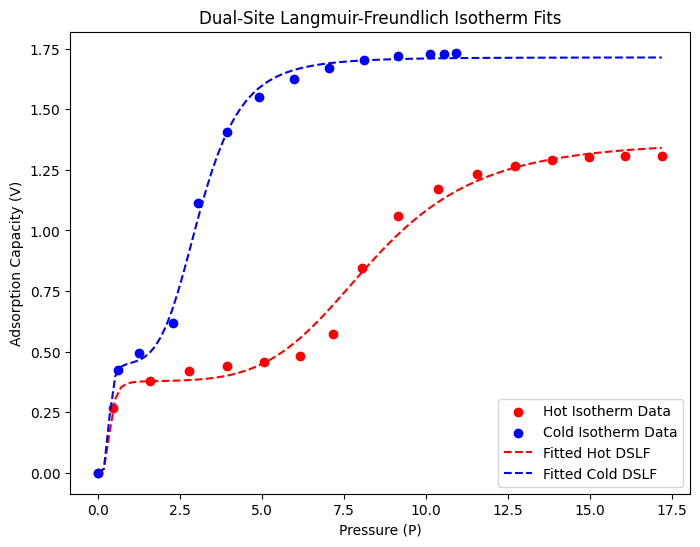

Hot Isotherm Parameters: [0.37848679 2.70655472 4.11058951 0.9887171  0.11979689 5.
 0.        ]
Cold Isotherm Parameters: [0.45058025 2.92556623 4.83970705 1.26385769 0.32157253 4.82777893
 0.        ]
ΔH1 = -2376.21 J/mol, ΔH2 = -30154.05 J/mol

Fitted Parameters for cold:
qm1  = 0.4506  (Capacity of Site 1)
K1   = 2.925566  (Langmuir Constant at reference T for Site 1)
n1   = 4.8397  (Freundlich exponent for Site 1)
qm2  = 1.2639  (Capacity of Site 2)
K2   = 0.321573  (Langmuir Constant at reference T for Site 2)
n2   = 4.8278  (Freundlich exponent for Site 2)
q_offset = 0.0000 (Offset)

Fitted Parameters for hot:
qm1  = 0.3785  (Capacity of Site 1)
K1   = 2.706555  (Langmuir Constant at reference T for Site 1)
n1   = 4.1106  (Freundlich exponent for Site 1)
qm2  = 0.9887  (Capacity of Site 2)
K2   = 0.119797  (Langmuir Constant at reference T for Site 2)
n2   = 5.0000  (Freundlich exponent for Site 2)
q_offset = 0.0000 (Offset)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, differential_evolution

# Dual-Site Langmuir-Freundlich (DSLF) Model with Temperature Dependence
def dslf_model(P, qm1, K1, n1, qm2, K2, n2, q_offset):
    term1 = (qm1 * (K1 * P) ** n1) / (1 + (K1 * P) ** n1)
    term2 = (qm2 * (K2 * P) ** n2) / (1 + (K2 * P) ** n2)
    return term1 + term2 + q_offset

# Van't Hoff Equation to Model Temperature Dependence of K
# K(T) = K_ref * exp(-ΔH / (R * T))
def vant_hoff(T, K_ref, delta_H):
    R = 8.314  # Gas constant in J/(mol*K)
    return K_ref * np.exp(-delta_H / (R * T))


# Fit DSLF Model to Hot Isotherm
def fit_dslf(P, V):
    bounds = [(0, 5), (1e-6, 10), (0.1, 5), (0, 5), (1e-6, 10), (0.1, 5), (0, 1)]
    # Change here: unpack to result to capture the success status in res
    res = differential_evolution(lambda x: np.sum((dslf_model(P, *x) - V) ** 2), bounds=bounds, strategy='best1bin', popsize=20)
    #return params #Removed
    return res.x # Added

# Given Isotherm Data
P_hot = np.array([0., 0.4569, 1.5710, 2.7626, 3.9219, 5.0416, 6.1487, 7.1699, 8.0331, 9.1313, 10.3655, 11.5593, 12.7129, 13.8412, 14.9685, 16.0784, 17.1915])
V_hot = np.array([0., 0.2669, 0.3788, 0.4196, 0.4411, 0.4583, 0.4830, 0.5743, 0.8447, 1.0597, 1.1703, 1.2314, 1.2672, 1.2898, 1.3016, 1.3069, 1.3065])
T_hot = 36 + 273.15  # Example Temperature in Kelvin

P_cold = np.array([10.5492, 10.9154, 10.1163, 9.1416, 8.0993, 7.0310, 5.9589, 4.9157, 3.9277, 3.0502, 2.2865, 1.2318, 0.6074,0])
V_cold = np.array([1.7277, 1.7338, 1.7301, 1.7213, 1.7026, 1.6721, 1.6243, 1.5493, 1.4070, 1.1121, 0.6161, 0.4953, 0.4235,0])
T_cold = 12 + 273.15  # Example Temperature in Kelvin



params_hot = fit_dslf(P_hot, V_hot)
params_cold = fit_dslf(P_cold, V_cold)

# Extract K1 and K2 for Temperature Dependence
K1_hot, K2_hot = params_hot[1], params_hot[4]
K1_cold, K2_cold = params_cold[1], params_cold[4]

# Fit Van't Hoff Equation to Extract ΔH
K1_values = np.array([K1_hot, K1_cold])
K2_values = np.array([K2_hot, K2_cold])
Temps = np.array([T_hot, T_cold])

params_vh1, _ = curve_fit(vant_hoff, Temps, K1_values, p0=[K1_hot, -5000],maxfev=10000)
params_vh2, _ = curve_fit(vant_hoff, Temps, K2_values, p0=[K2_hot, -5000],maxfev=10000)

# Extract ΔH values
delta_H1, delta_H2 = params_vh1[1], params_vh2[1]

# Plot Fitted Isotherms
plt.figure(figsize=(8,6))
plt.scatter(P_hot, V_hot, label='Hot Isotherm Data', color='red')
plt.scatter(P_cold, V_cold, label='Cold Isotherm Data', color='blue')
P_fit = np.linspace(0, max(P_hot.max(), P_cold.max()), 100)
plt.plot(P_fit, dslf_model(P_fit, *params_hot), 'r--', label='Fitted Hot DSLF')
plt.plot(P_fit, dslf_model(P_fit, *params_cold), 'b--', label='Fitted Cold DSLF')
plt.xlabel('Pressure (P)')
plt.ylabel('Adsorption Capacity (V)')
plt.legend()
plt.title('Dual-Site Langmuir-Freundlich Isotherm Fits')
plt.show()

# Print Extracted Parameters
print(f"Hot Isotherm Parameters: {params_hot}")
print(f"Cold Isotherm Parameters: {params_cold}")
print(f"ΔH1 = {delta_H1:.2f} J/mol, ΔH2 = {delta_H2:.2f} J/mol")

# Extract optimized parameters from differential evolution result
qm1_cold, K1_ref_cold, n1_cold, qm2_cold, K2_ref_cold, n2_cold, q_offset_cold = params_cold # Added q_offset as 7th element

# Print results clearly
print("\nFitted Parameters for cold:")
print(f"qm1  = {qm1_cold:.4f}  (Capacity of Site 1)")
print(f"K1   = {K1_ref_cold:.6f}  (Langmuir Constant at reference T for Site 1)")
print(f"n1   = {n1_cold:.4f}  (Freundlich exponent for Site 1)")
print(f"qm2  = {qm2_cold:.4f}  (Capacity of Site 2)")
print(f"K2   = {K2_ref_cold:.6f}  (Langmuir Constant at reference T for Site 2)")
print(f"n2   = {n2_cold:.4f}  (Freundlich exponent for Site 2)")
print(f"q_offset = {q_offset_cold:.4f} (Offset)") # Print q_offset
#print(f"dH1  = {dH1:.2f} kJ/mol  (Enthalpy change for Site 1)") #Removed as this doesn't exist in your function
#print(f"dH2  = {dH2:.2f} kJ/mol  (Enthalpy change for Site 2)") #Removed as this doesn't exist in your function


# Extract optimized parameters from differential evolution result
qm1_hot, K1_ref_hot, n1_hot, qm2_hot, K2_ref_hot, n2_hot, q_offset_hot = params_hot # Added q_offset as 7th element

# Print results clearly
print("\nFitted Parameters for hot:")
print(f"qm1  = {qm1_hot:.4f}  (Capacity of Site 1)")
print(f"K1   = {K1_ref_hot:.6f}  (Langmuir Constant at reference T for Site 1)")
print(f"n1   = {n1_hot:.4f}  (Freundlich exponent for Site 1)")
print(f"qm2  = {qm2_hot:.4f}  (Capacity of Site 2)")
print(f"K2   = {K2_ref_hot:.6f}  (Langmuir Constant at reference T for Site 2)")
print(f"n2   = {n2_hot:.4f}  (Freundlich exponent for Site 2)")
print(f"q_offset = {q_offset_hot:.4f} (Offset)") # Print q_offset
#print(f"dH1  = {dH1:.2f} kJ/mol  (Enthalpy change for Site 1)") #Removed as this doesn't exist in your function
#print(f"dH2  = {dH2:.2f} kJ/mol  (Enthalpy change for Site 2)") #Removed as this doesn't exist in your function





This is Peter's code

In [ ]:
#Install CoolProp to get Real CO2 data
!pip install -vvv --pre --trusted-host www.coolprop.dreamhosters.com --find-links http://www.coolprop.dreamhosters.com/binaries/Python/ -U --force-reinstall CoolProp

Using pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)
Non-user install because site-packages writeable
Created temporary directory: /tmp/pip-build-tracker-ykyyz7ir
Initialized build tracking at /tmp/pip-build-tracker-ykyyz7ir
Created build tracker: /tmp/pip-build-tracker-ykyyz7ir
Entered build tracker: /tmp/pip-build-tracker-ykyyz7ir
Created temporary directory: /tmp/pip-install-puixk8g2
Created temporary directory: /tmp/pip-ephem-wheel-cache-ndzeuj_7
Looking in links: http://www.coolprop.dreamhosters.com/binaries/Python/
2 location(s) to search for versions of coolprop:
* http://www.coolprop.dreamhosters.com/binaries/Python/
* https://pypi.org/simple/coolprop/
Fetching project page and analyzing links: http://www.coolprop.dreamhosters.com/binaries/Python/
Getting page http://www.coolprop.dreamhosters.com/binaries/Python/
Looking up "http://www.coolprop.dreamhosters.com/binaries/Python/" in the cache
Request header has "max_age" as 0, cache bypassed
No cache e

In [ ]:
#### Trying again, let's go fix all the units, try putting EVERYTHING in mol/kg instead of this insane /m^3 setup
#Using: https://sci-hub.se/https://doi.org/10.1016/S1359-4311(98)00013-1 as a reference for this work
#Making a major modification, instead of doing their "two chambers" design, treating this as a closed system that can change volume to trigger pressure / adsorption changes

from re import M
#%reset
import numpy as np
import matplotlib.pyplot as plt

import CoolProp
from CoolProp.CoolProp import PropsSI

from scipy.optimize import fsolve, root_scalar, root

# Now include all the functions
#Here is the isotherm function based on Petter's code and sorption data
'''
def isotherm(P, T):
    """
    Langmuir-like isotherm equation.
    :param P: Pressure (Pa)
    :param T: Temperature (K)
    :return: loading of CO2 (mol/kg)
    """
    #n_a is moles adsorbed on activated carbon

    #Using a Langmuir fit
    #b = bo * np.exp(H_ads/(R*T))                            # This gives K equilibrium constant = bp/1+bp
    #n_a = n_sat * (P*b / (1 + P*b))


    #Using the Toth Equation Fit

    b = b0 * np.exp(lambda_st/(R*T))                            # This gives K equilibrium constant = bp/1+bp
    n_a = n_sat * b * P / (1 + (b*P)**t_h)**1/t_h

    return n_a # This is in mol/kg
'''
'''
def isotherm_For_P(n_a, T):
    """
    Langmuir-like isotherm equation.
    :param P: n_a (mol/kg)
    :param T: Temperature (K)
    :return: corresponding pressure (Pa)
    """
    #n_a is moles adsorbed on activated carbon

    #Now, solving using the Toth equation
    #Guess P based on the langmuir isotherm

    b = b0 * np.exp(lambda_st/(R*T))                            # This gives K equilibrium constant = bp/1+bp
    P_guess = n_a / (b*(n_sat - n_a))

    toth = lambda P : n_a - (n_sat * b * P / (1 + (b*P)**t_h)**1/t_h)

    P = fsolve(toth, P_guess)

    return float(P) # This is in Pa
'''

#This is MOF isotherm
def isotherm(P, T_run):

    T_mid = T_run
    # Define the known temperature array
    T_array = np.array([T_cold, T_hot])

    # Interpolate using np.interp (faster than interp1d)
    qm1_mid = np.interp(T_mid, T_array, [qm1_cold, qm1_hot])
    qm2_mid = np.interp(T_mid, T_array, [qm2_cold, qm2_hot])
    n1_mid = np.interp(T_mid, T_array, [n1_cold, n1_hot])
    n2_mid = np.interp(T_mid, T_array, [n2_cold, n2_hot])

    # Van't Hoff for K values (temperature-dependent)
    K1_mid = K1_ref_hot * np.exp((-delta_H1/R) * (1/T_mid - 1/T_hot))
    K2_mid = K2_ref_hot * np.exp((-delta_H2/R) * (1/T_mid - 1/T_hot))

    #Use the interpolated values in the calculations
    term1 = (qm1_mid * (K1_mid * P/1e5) ** n1_mid) / (1 + (K1_mid * P/1e5) ** n1_mid)
    term2 = (qm2_mid * (K2_mid * P/1e5) ** n2_mid) / (1 + (K2_mid * P/1e5) ** n2_mid)
    sorb = term1 + term2

    return sorb


def isotherm_For_P(n_a, T_run, p_current):
    """
    Finds a new P given an n_a and a temperature.
    params:
    n_a, number of moles
    T_run, current temperature
    p_current, current pressure
    returns:
    P, new pressure
    """
    #n_a is moles adsorbed on activated carbon

    #Now, solving using the Toth equation
    #Guess P based on the langmuir isotherm
    '''
    p_h = p_current * 1.25
    p_l = p_current * 0.75
    p_guess = p_current
    print('p_current', p_current)

    n_a_guess = isotherm(p_current, T_run)
    counter = 0

    while(abs(n_a_guess - n_a) > 1e-3):
        if n_a_guess > n_a:
            p_l = p_guess
            p_current = (p_l + p_h) / 2
        else:
            p_h = p_guess
            p_guess = (p_l + p_h) / 2
        n_a_guess = isotherm(p_guess, T_run)
        print('na', n_a, 'n_a_guess', n_a_guess)
        print('p_guess', p_guess)
        counter = counter + 1
        if counter > 100:
          break
    return p_guess
    '''



    n_a_transition = 0.4                                               #This is where the first Langmuir flattens out
    n_sat = 1.7                                                         #This is where second Langmuir flattens out

    if n_a < n_a_transition:
        b0 = qm1_cold
        lambda_st = delta_H1
        n_sat = n_a_transition
        b = b0 * np.exp(lambda_st/(R*T_run))                            # This gives K equilibrium constant = bp/1+bp
        P_guess = n_a / (b*(n_sat - n_a))
    else:
        b0 = qm1_hot
        lambda_st = delta_H2
        b = b0 * np.exp(lambda_st/(R*T_run)) + n_a_transition                           # This gives K equilibrium constant = bp/1+bp
        P_guess = n_a / (b*(n_sat - n_a))



    T_mid = T_run
    # Define the known temperature array
    T_array = np.array([T_cold, T_hot])

    # Interpolate using np.interp (faster than interp1d)
    qm1_mid = np.interp(T_mid, T_array, [qm1_cold, qm1_hot])
    qm2_mid = np.interp(T_mid, T_array, [qm2_cold, qm2_hot])
    n1_mid = np.interp(T_mid, T_array, [n1_cold, n1_hot])
    n2_mid = np.interp(T_mid, T_array, [n2_cold, n2_hot])

    # Van't Hoff for K values (temperature-dependent)
    K1_mid = K1_ref_hot * np.exp((-delta_H1/R) * (1/T_mid - 1/T_hot))
    K2_mid = K2_ref_hot * np.exp((-delta_H2/R) * (1/T_mid - 1/T_hot))

    #Use the interpolated values in the calculations
    #term1 = (qm1_mid * (K1_mid * P/1e5) ** n1_mid) / (1 + (K1_mid * P/1e5) ** n1_mid)
    #term2 = (qm2_mid * (K2_mid * P/1e5) ** n2_mid) / (1 + (K2_mid * P/1e5) ** n2_mid)
    #sorb = term1 + term2

    toth = lambda P : n_a - ((qm1_mid * (K1_mid * P/1e5) ** n1_mid) / (1 + (K1_mid * P/1e5) ** n1_mid)) - ((qm2_mid * (K2_mid * P/1e5) ** n2_mid) / (1 + (K2_mid * P/1e5) ** n2_mid))

    #P = fsolve(toth, P_guess)
    P = root(toth, P_guess, method='hybr')

    return float(P.x[0]) # This is in Pa






def H_ads_var(P, T):
  '''
  Varying H_ads per Pressure and temperature, using a modified "Dubinin-Astakhov (D-A)" model
  Source: https://sci-hub.se/10.1021/je100973t

  This model allows for the enthalpy of adsorption to change at different P and T
  :param P: Pressure (Pa)
  :param T: Temperature (K)
  :return: enthalpy of adsorption (J/mol)

  Equation:

  H_ads = k*R*T + A + alpha/n * TE**n*A**(1-n) + Tv_g(dP/dT)


  Issue: because H_ads changes with T and P, this throws off our integration. Do not use this function for now

  '''


  #various parameters, from paper. Kept here to avoid poluting rest of program

  k_DA = 4.49
  W0 = 0.001759 #m^3/kg
  E_DA = 4159.89 #J/mol
  n_DA = 1.18
  if T < 304:
    P_S = PropsSI('P', 'T', T, 'Q', 1, 'CO2') #Saturation vapor pressure (Pa)
  else:
    P_S = (T / 304.15)**2 * 7.38E6 #to account for going over the critical temp/pressure

  A = R * T * np.log(P_S / P) #Adsorption potential -> paper suggests
  alpha = 0.0025 #
  v_g = 1/ PropsSI('DMOLAR', 'T', T, 'P', P, 'CO2')




  H_ads = k_DA * R * T + A + alpha / n_DA * T * (E_DA**n_DA) * (A**(1-n_DA)) + T*v_g*C_p


  return H_ads

def find_V(P, T):
  #Attempting to reimagine the system as our bed hooked up to a magic piston
  #V is the volume of the piston + chamber at any point in time, adjusts according to the amount of gas sorbed
  #Input is P (Pa), T (K), uses global varible ngMax in the find_ng method
  #Returns V, in m^3
  dmol = PropsSI('DMOLAR', 'P', P, 'T', T, 'CO2') #Molar density (mol / m^3) of real CO2

  V = find_ng(P,T) * 1/dmol #* R * T / P now solving for real volume as opposed to ideal volume

  return V

def find_ng(P,T):
  #Attempting to move everything to a 1 kg basis to avoid our terrible conversion issues
  #ngMax is the max mole that could ever be in the gas phase, which is the known "end loading"
  #ng is the number of mole in the gas phase
  #we calculate an ng by finding the number of adsorbed mole from the isotherm, and take them out of hte gas phase


  ng = ngMax - isotherm(P,T)

  return ng




#Adiabatic steps
# Differential equations for adiabatic operation (Eq. 20)
def adiabatic_step(T, P, dna):
    """
    Adiabatic step based on Eq. 20.
    :param T: Temperature (K)
    :param P: Pressure (Pa)
    :param dna: Change in moles sorbed in AC (mol)
    :return: dT/dna, DP/dna, and two work calculations. The second is accurate / corrected
    """

########################################################################################
    #For adam / Jinyoung if you look at this notebook
    #I realized I hadn't checked the first law for a while, and I'm actually a tick off
    #Something must be up here in the adiabatic step, it isn't obvious to me though
##########################################################################################


    #Our adiabatic equation is:
    # [(Cs + na*Cp) + V*P/RT*Cp] DT + DeltaH*dNa - PdV - VdP = dQ -> Basically equation 11 from the paper.
    # Now, we will break this out, but in terms of dNa instead, since that is our thing we're changing
    # Full equation, now looks like:
    # [(Cs + na*Cp) + V*P/RT * Cp - P*dV/dT - V*dP/dT]dT + [delH - P*dv/dn - V*dP/dn]dna = 0
    # DQ set to zero because adiabatic

    n_a = isotherm(P, T) #n_a is the number of mol adsorbed in the AC
    V = find_V(P,T) #finding volume before adiabatic step
    n_g = find_ng(P,T) #finding number of mol gas in the vapor phase
    dV_dT = -C_v * n_g / P  #Under adiabatic conditions of an ideal gas, change in energy (dE = n*Cv*dT = -PdV. Solving gets me dV/dT)
    dP_dT = (C_p * n_g) / V  #I spent an embarassing amount of time re-deriving the relationship between Cp and Cv
    Z = PropsSI('Z', 'P', P, 'T', T, 'CO2')


    #This is the dT/dNa differential, broken up into three terms to be reasonable to look at
    term1 = (C_s + binderFraction * C_b +  (n_a) * C_p) + n_g * C_p  #This term captures the sensible heating of the gas and the solid (Cs is the heat for the activated carbon, na*Cp is heating the adsorbed CO2, the VP/RT*Cp is the moles of free gas getting heated)
    term2 = -P*dV_dT - V*dP_dT #Here are the corrections for volume and pressure changing with temperature). Term 1 and Term 2 make up the left side of the equation
    term3 = lambda_st + 2*Z*R*T # including Z to account for compressibility #- P*dV_dna - V*dP_dna #These are the terms in the dNa block. I've been driven nuts by thinking about the enthalpy sign. -> Issue may have been here, the PV / VP could be solved as 2* NRT, dg/dna = -1

    dT_dna = term3 / (term1 + term2) #solving the big dT/dna equation


    newT = T + dT_dna * dna

    #recalculate with changing T and P
    #I think this is the last source of inaccuracy, I think the issue is that there is an interaction term between the pressure and number of moles of gas that makes simply looking at the isotherm inaccurate
    #However, it isn't obvious to me why this isn't cooperating.

    #newP = P / ( (T / newT)**(gamma / (gamma - 1)) ) #This didn't work, is some term off?
    newP = isotherm_For_P(n_a + dna, newT, P)
    newV = find_V(newP, newT)

    dP_dna = (newP - P)/dna #These are updated again, now with changing T
    dV_dna = (newV - V)/dna


    #dW_dnt_PV = (n_g/(1-gamma) * (newP * newV - P*V))  #This term is not used. Pressure calculation is less accurate than the temperature one  #This is a PdV calculation for work. Could be off because it assumes T is constant. This is wrong. Also, didn't chain rule out the ng, so that is also wrong
    ####### accounting for the change in ng wrt na. dng/dna = -1, they are inverses of each other
    #W = ng*deltaT*R/gamma
    #dW/dna = d/dna (deltaT) * ng*R/gamma + dng/dna * deltaT * ng*R/gamma
    #dW_dnt_TV = n_g*dT_dna * (R / (gamma - 1))         #This should be an equivalent version of work done during adaibatic process. This could be more correct, since it allows for everything to move

    #dW = n_g*dT_dna*dna* (R / (gamma - 1))

    #dW_dna = - R / (gamma - 1) * ( -T + newT - n_g*dT_dna)
    dW_dna = n_g * C_v * (newT - T) / dna  #do I need to incorporate a correction for n_g?

    #dW_dna = -C_v * (newT - T) + n_g*C_v*dT_dna #This differs from the above dW_dna by about 1%, but actually makes our first law violation a smidge worse.

    return dT_dna, dP_dna, dW_dna


# Differential equations for isothermal operation (Eq. 17)
def isothermal_step(P, T, dna): # This is finding how much heat is transfered and pressure increased per unit of mole of gas,
    """
    Isothermal step based on Eq. 17 -> now very modified in terms of volume changing piston
    :param P: Pressure (Pa)
    :param T: Temperature (K)
    :param T_flow: Flow temperature (K)
    :return: dQ/dna (J/mol)
    """

#Calculate variables and differentials

    current_n = isotherm(P, T) #number of mol adsorbed
    new_n = current_n + dna  #incrimenting by step size

    n_g = find_ng(P,T) #Number of mol in gas phase

    new_P = isotherm_For_P(new_n, T, P) #find new pressure from isotherm
    dP_dna = (new_P - P)/dna #dp/dna determined linearly, delta P / delta N

    V = find_V(P,T) #calculate original volume
    new_V = find_V(new_P,T) # calculate volume after shift
    dV_dna = (new_V - V)/dna #dV/dna as linear delta V / delta N


 #Q = enthalpy + d/dna (PV).
 #Lambda_ST is the enthalpy of DESORPTION, I've been driven mad trying to determine the right signs for everything


    dQ_dna = (lambda_st - V*dP_dna - P*dV_dna)                                #This number is close to what I'd expect. However, I'd expect heat to go up from the gas,


#W = n_g * R * T * ln (P1/P2). n_g and P2 are functions of dna, so differentiating
#Sign is set to ensure compression is postive, expansion is negative to match our sign convention


#Re-examine this term tomorrow,
    dW_dna = - R*T*(np.log(P/new_P) - n_g*dP_dna/new_P)



    return dQ_dna, dP_dna, dW_dna


################################################################################


# Integrating the adiabatic steps

def runge_kutta_4_adiabatic_increase(T0, P0, h):
    """
    RK4 for adiabatic steps.
    :param T0: Initial temperature (K)
    :param P0: Initial pressure (Pa)
    :param h: Step size (moles)
    :param steps: Number of steps
    :return: Arrays of temperature and pressure.
    """
    T = T0
    P = P0
    temperatures = [T]
    pressures = [P]
    na_ad = [0]

    W_TV = 0
    work_ad_TV = [W_TV]

    na_ad.append(isotherm(P,T))

    #for _ in range(steps):                                                #Once the code works, change this to a while loop so that it only stops when the T crosses the high temp isotherm
    while T < T_hot:

        dT, dP, dW_TV = adiabatic_step(T, P, h)                                  # Get dT and dP from adiabatic_step
        k1 = h * dT                                                       # Multiply dT by h
        p1 = h * dP                                                       # Multiply dP by h
        m1 = h* dW_TV

        dT, dP,  dW_TV = adiabatic_step(T + k1 / 2, P + p1 / 2, h)                         # Get dT and dP
        k2 = h * dT
        p2 = h * dP
        m2 = h* dW_TV

        dT, dP,  dW_TV = adiabatic_step(T + k2 / 2, P + p2 / 2, h)                         # Get dT and dP
        k3 = h * dT
        p3 = h * dP
        m3 = h * dW_TV

        dT, dP, dW_TV = adiabatic_step(T + k3, P + p3, h)                             # Get dT and dP
        k4 = h * dT
        p4 = h * dP
        m4 = h * dW_TV

        T = T + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        P = P + (p1 + 2 * p2 + 2 * p3 + p4) / 6
        W_TV = W_TV + (m1 + 2 * m2 + 2 * m3 + m4) / 6
        # Append the new value to the na_iso list
        na_ad.append(isotherm(P,T))                                    #This is tracking how much CO2 is sorbed as P and T change, following the new isotherms


        temperatures.append(T)
        pressures.append(P)

        work_ad_TV.append(W_TV)

    return np.array(temperatures), np.array(pressures), np.array(na_ad),  np.array(work_ad_TV)


# Runge-Kutta 4th-order implementation for isothermal steps
def runge_kutta_4_isothermal_increase(T, h, P_start):
    """
    RK4 for isothermal steps.
    :param P0: Initial pressure (Pa)
    :param T: Temperature (K)

    :param h: Step size (moles)
    :param steps: Number of steps
    :return: Arrays of pressure and heat transferred.
    """
    P = P_start
    Q = 0.0
    W = 0

    pressures = [P]
    heat_transfers = [Q]
    gas_heat = [W]

    na_iso = [0]

    na_iso.append(isotherm(P,T_hot))


    while P < P_high:

        # Change here: unpack the result of isothermal_step into two variables
        dQ, dP, dW = isothermal_step(P, T, h)
        k1 = h * dQ                                                               # Multiply dQ_dnt by h
        p1 = h * dP
        w1 = h* dW                                                               # Multiply dP_dnt by h




        dQ, dP, dW = isothermal_step(P + p1 / 2, T, h)
        k2 = h * dQ
        p2 = h * dP
        w2 = h* dW



        dQ, dP, dW = isothermal_step(P + p2 / 2, T, h)
        k3 = h * dQ
        p3 = h * dP
        w3 = h*  dW



        dQ, dP, dW = isothermal_step(P + p3, T, h)
        k4 = h * dQ
        p4 = h * dP
        w4 = h*dW



        P = P + (p1 + 2 * p2 + 2 * p3 + p4) / 6
        Q = Q +  (k1 + 2 * k2 + 2 * k3 + k4) / 6
        W = W + (w1 + 2 * w2 + 2 * w3 + w4) / 6
        #Q = isothermal_step(P, T, T_flow)
        na_iso.append(isotherm(P,T_hot))


        pressures.append(P)
        heat_transfers.append(Q)
        gas_heat.append(W)

    return np.array(pressures), np.array(heat_transfers), np.array(na_iso), np.array(gas_heat)



#Reverse functions
# Integrating the adiabatic steps

def runge_kutta_4_adiabatic_decrease(T1, P1, h):
    """
    RK4 for adiabatic steps.
    :param T0: Initial temperature (K)
    :param P0: Initial pressure (Pa)
    :param h: Step size (moles)
    :param steps: Number of steps
    :return: Arrays of temperature and pressure.
    """
    T = T1
    P = P1
    temperatures = [T]
    pressures = [P]
    na_ad = [0]


    W_TV = 0
    work_ad_TV = [W_TV]
    h = -h

    na_ad.append(isotherm(P,T))


    while T > T_cold:

        dT, dP, dW_TV = adiabatic_step(T, P, h)                                  # Get dT and dP from adiabatic_step
        k1 = h * dT                                                       # Multiply dT by h
        p1 = h * dP                                                       # Multiply dP by h

        m1 = h * dW_TV

        dT, dP, dW_TV = adiabatic_step(T + k1 / 2, P + p1 / 2, h)                         # Get dT and dP
        k2 = h * dT
        p2 = h * dP

        m2 = h * dW_TV

        dT, dP, dW_TV = adiabatic_step(T + k2 / 2, P + p2 / 2, h)                         # Get dT and dP
        k3 = h * dT
        p3 = h * dP

        m3 = h * dW_TV

        dT, dP, dW_TV = adiabatic_step(T + k3, P + p3, h)                             # Get dT and dP
        k4 = h * dT
        p4 = h * dP

        m4 = h * dW_TV

        T = T + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        P = P + (p1 + 2 * p2 + 2 * p3 + p4) / 6

        W_TV = W_TV + (m1 + 2 * m2 + 2 * m3 + m4) / 6
        # Append the new value to the na_iso list
        na_ad.append(isotherm(P,T))                                    #This is tracking how much CO2 is sorbed as P and T change, following the new isotherms


        temperatures.append(T)
        pressures.append(P)

        work_ad_TV.append(W_TV)


    return np.array(temperatures), np.array(pressures), np.array(na_ad), np.array(work_ad_TV)



# Runge-Kutta 4th-order implementation for isothermal steps
def runge_kutta_4_isothermal_decrease(T, h, P_start):
    """
    RK4 for isothermal steps.
    :param P0: Initial pressure (Pa)
    :param T: Temperature (K)
    :param T_flow: Flow temperature (K)
    :param h: Step size (moles)
    :param steps: Number of steps
    :return: Arrays of pressure and heat transferred.
    """
    P = P_start
    pressures = [P]
    heat_transfers = [0]
    Q=0
    W = 0
    H = 0
    gas_heat = [W]
    adsorb_heat = [H]
    na_iso = [0]
    h = -h #negative to "step down"

    na_iso.append(isotherm(P,T_cold))

    while P > P_low:

        # Change here: unpack the result of isothermal_step into two variables
        dQ, dP, dW = isothermal_step(P, T, h)
        k1 = h * dQ
        p1 = h * dP
        w1 = h * dW


        dQ, dP, dW = isothermal_step(P + p1 / 2, T, h)
        k2 = h * dQ
        p2 = h * dP
        w2 = h * dW


        dQ, dP, dW = isothermal_step(P + p2 / 2, T, h)
        k3 = h * dQ
        p3 = h * dP
        w3 = h * dW


        dQ, dP, dW = isothermal_step(P + p3, T, h)
        k4 = h * dQ
        p4 = h * dP
        w4 = h * dW


        P = P + (p1 + 2 * p2 + 2 * p3 + p4) / 6
        Q = Q + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        W = W + (w1 + 2 * w2 + 2 * w3 + w4) / 6


        na_iso.append(isotherm(P,T_cold))


        pressures.append(P)
        heat_transfers.append(Q)
        gas_heat.append(W)




    return np.array(pressures), np.array(heat_transfers), np.array(na_iso), np.array(gas_heat)



In [ ]:
############################################################################################################################################
############################################################################################################################################
#Base case, checking pressure ratios vs COP

################################################################################
#Physical Constants
################################################################################
R = 8.314                                                 #J/mol*K
C_p = 37.1                                   # This is heat capacity of CO2 kJ/kmol K or J/mol K
gamma = 37.1 / 28.95                        #Adaiabatic Index for CO2
C_v = 28.95 #J/molK


################################################################################
#Activated Carbon Constants
################################################################################
#H_ads = 20.56*1000                                             #Enthalpy of adsorption, J/mol Source: https://sci-hub.se/10.1021/je100973t
#lambda_st = H_ads                           # J/mol, fixing terminology for what is used in the simulation. NOTE: lambda is heat of DESORPTION, so should be positive
#bo = 1.06E-10            #Units - Pa, source: https://sci-hub.se/10.1021/je100973t
#n_sat = 2.21*1000/44                                       #Langmuir saturation, mmol/g (or mol/kg) material dependent (source: https://sci-hub.se/10.1021/je100973t, given in kg/kg)
'''
#For Toth Equation: parameters from https://sci-hub.se/10.1021/je100973t , can also look at https://sci-hub.se/https://doi.org/10.1016/j.ijheatmasstransfer.2016.12.114
H_ads = 20.37*1000 #J/mol,
lambda_st = H_ads
b0 = 1.17e-10 #Pa
t_h = 0.664 #heterogeneity parameter for toth equation, unitless
n_sat =  3.06*1 / (44.009/1000) #Saturation concentration, mmol/g
'''
''' Alternative set of parameters, from  https://sci-hub.se/https://doi.org/10.1016/j.ijheatmasstransfer.2016.12.114.
I made a pass at fitting our sorption curves, I see an n_sat of ~40 mmol/g, which corresponds to ~2 kg/kg / matches expectations
However, the b0 and H values are significantly off, need more data to get a more believable fit here / the slope depends very strongly on small changes in measurement.
Keeping one of hte literature values is likely more accurate

Other paper's parameters give worse predictions, but the difference isn't that major. Will need to do a VERY careful sweep of lots of temperatures and pressures to get an accurate fitting on our final material

The values:
'''

#This is from the fit above
delta_H1 = -1435.66
delta_H2 = -30171.97

qm1_cold = 0.4495
K1_ref_cold = 2.920579
n1_cold = 4.9940
qm2_cold = 1.2651
K2_ref_cold = 0.321698
n2_cold = 4.8189
q_offset_cold = 0

qm1_hot = 0.3787
K1_ref_hot = 2.786454
n1_hot = 3.5771
qm2_hot = 0.9884
K2_ref_hot = 0.119774
n2_hot = 5
q_offset_hot = 0.0001



H_ads = 30*1000 #J/mol,
lambda_st = H_ads
b0 = 1.842e-10 #Pa
t_h = 0.799 #heterogeneity parameter for toth equation, unitless
n_sat =  2.3601*1 / (44.009/1000) #Saturation concentration, mmol/g



'''
'''

rho_b = 480                                # This is the density of the adsorbant activated carbon, kg/m^3
C_s = 800                                    # This is heat capacity of activated carbon, J/kg K

C_b = 1.5*1000                              #Heat capacity of binder. Assuming 1.5 J/g k for now, which is in the middle for most polymers. We'll account for this, but not the heat capacity of the Cu
binderFraction = 0.05 #0.05


################################################################################
#Variables and Simulation Parameters
################################################################################
T_cold = 283                                              #Cold temperature, K
T_hot = 323                                               #Hot temperature, K
T0 = T_cold

ng_multiplier = 1 #Multiplier for ng_max

num_stages = 1                                           #This is how many stages in this regenerator
h = 0.1

#Sorption isotherm pressure                     #This is the pressures we want the isotherms to graph at
P_sorption_max = 3e6
P_sorption_min = 0


################################################################################
################################################################################




################################################################################
#Set up temperature, pressure, and variable arrays
################################################################################

#Pick the temperatures of the isotherms
T_middle = np.zeros(num_stages-1)                         #This is how many intermediate isotherms we need to run the stages
for i in range(len(T_middle)):
    T_middle[i] = T_cold + (T_hot - T_cold) / (num_stages) * (i+1)
T_array = np.concatenate((np.array([T_cold]), T_middle, np.array([T_hot])))                             #This is all the temperature data


#Setting up the pressure sweep
lowP = 1
#This is a for loop to cycle over different pressure swings
#P_array_low = [1, 1, 1, 1, 1 , 1, 1, 1, 1, 1, 1]             #These are in bar
#P_array_low = [x * lowP for x in P_array_low]             #set the low pressure to be lower, if we want to
#P_array_high = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]           #Need to be the same length as P_array_low
P_array_low = [1.5,1.5,1.5]
P_array_high = [8,10,12]


#Set up array for storing COP, and the pressure ratio
COP_array = np.zeros(len(P_array_high))                           #This is the COP given a run
P_diff = np.zeros(len(P_array_high))                              #This is the pressure swing for each run

#Final arrays to store data
COP_data = np.zeros((num_stages,len(P_array_low)))                #This holds the COP data, rows are at a given stage, columns are the different pressure ratios in that stage
heat_data = np.zeros((num_stages,len(P_array_low)))               #This is the heat data
cold_data = np.zeros((num_stages,len(P_array_low)))               #This is the heat data, for cooling
work_data = np.zeros((num_stages,len(P_array_low)))               #This is the work data



#For each pressure ratio, draw a cycle and analyze work + COP

for k in range(len(P_array_low)):
  #This runs over the different temperatures
    #Now do the standard analysis for one stage and store the data

    total_iso_work = 0
    total_ad_work_PV = 0
    total_ad_work_TV = 0
    total_work = 0
    total_heat = 0
    #COP = 0

    for j in range(num_stages):
        T_cold = T_array[j]
        T_hot = T_array[j+1]

        P_low = P_array_low[k] * 1e5
        P_high = P_array_high[k] * 1e5
        P0 = P_low
        P1 = P_high
        P_diff[k] = P_high / P_low                              #This is keeping track of the pressure swing
        COP = 0

        print("The pressure swing is from " + str(P_low/1e5) + " bar to " + str(P_high/1e5) + " bar")


        P_test = np.linspace(P_sorption_min, P_sorption_max, 50)                         #This is the code for Peter's isotherms
        n_cold = isotherm(P_test, T_cold) #Units mol/kg
        n_hot = isotherm(P_test, T_hot)   #Units mol/kg

        start_pressure = 0;
        end_pressure = 0;
        start_loading = 0;
        end_loading = 0;

        #This finds the bounds on loading based on the input pressure range
        for i in range(len(P_test)):
            if P_low >= min(P_test):
                start_pressure = min(P_test, key = lambda x:abs(x-P_low))
                start_loading = n_cold[np.where(P_test == start_pressure)[0][0]]
                print("The start pressure is " + str(start_pressure/1e5) + " bar")
                print("The start loading is " + str(start_loading) + " mol/kg")
                break
            else:
                print("Input low pressure is out of range")
                break

        for i in range(len(P_test)):

            if P_high <= max(P_test):
                end_pressure = min(P_test, key = lambda x:abs(x-P_high))
                end_loading = n_hot[np.where(P_test == end_pressure)[0][0]]
                break
            else:
                print("Input high pressure is out of range")
                break

        #Now find how many mol/kg the system will used based on the selected pressures
        n_t_low = start_loading
        n_t_high = end_loading
        #######################################################################
        #NGMAX SET HERE. Last "major" variable to set.
        #without correction, this is the number of mol at full loading
        #Multiple by a factor (x1.25 or something) to better mimic a 'real' system
        #######################################################################
        Z = PropsSI('Z', 'P', P_high, 'T', T_hot, 'CO2')
        ng_adder = P_high * (1/rho_b) / (Z * R * T_hot) #This is the number of moles of gas that would fit in the volume of the activated carbon bed at the high pressure/high temperature condition. This will overestimate the minimum number of extra moles we would need (as there is also AC there)
        ngMax = ng_multiplier*isotherm(P_high, T_hot) + ng_adder #isotherm(P_high, T_cold) #n_t_high + n_t_low #isotherm(P_high, T_cold) #needs to be higher becuase capacity is higher for the cold isotherm
                                                      # This is the step size in moles/kg

        total_n_t = n_t_high - n_t_low
        steps = int(total_n_t / h)
        print("The total number of mol/kg is " + str(total_n_t))
        print("We have " + str(steps) + " steps total")



        #This is the curve starting from the low pressure, low temp isotherm
        #First do adiabatic operation until T crosses the high temp isotherm
        # Adiabatic step simulation
        temperatures_ad, pressures_ad, na_ad, work_ad_TV = runge_kutta_4_adiabatic_increase(T_cold, P0, h)
        P_end_ad = pressures_ad[-1]


        #Now do isothermal operation on the high temp isotherm
        # Isothermal step simulation
        pressures_iso, heat_transfers, na_iso, gas_heat = runge_kutta_4_isothermal_increase(temperatures_ad[-1], h, P_end_ad)
        P1 = pressures_iso[-1]


        #This is the curve starting at high pressure, high temperature isotherm
        #First do adiabatic operation until T crosses the low temp isotherm
        # Adiabatic step simulation
        temperatures_ad2, pressures_ad2, na_ad2, work_ad_TV2 = runge_kutta_4_adiabatic_decrease(temperatures_ad[-1], P1, h)
        P_end_ad2 = pressures_ad2[-1]

        #Now do isothermal operation on the low temp isotherm
        # Isothermal step simulation
        pressures_iso2, heat_transfers2, na_iso2, gas_heat2 = runge_kutta_4_isothermal_decrease(temperatures_ad2[-1], h, P_end_ad2)

        #Now plot the adiabatic steps on the graph
        plt.plot(P_test/1e5, n_cold, 'b-', label = "Cold T = " + str(T_cold) + "K")
        plt.plot(P_test/1e5, n_hot, 'r-', label = "Hot T = "  +str(T_hot) + "K")
        plt.plot(pressures_ad/1e5, na_ad[1:], 'm--', label = "Adiabatic operation curve")
        plt.plot(pressures_iso/1e5, na_iso[1:], 'g--', label = "Isothermal curve")
        plt.plot(pressures_ad2/1e5, na_ad2[1:], 'c--', label = "Adiabatic operation curve")
        plt.plot(pressures_iso2/1e5, na_iso2[1:], 'y--', label = "Isothermal curve")
        plt.grid(visible=True, which='major', color='k', linestyle='--')
        plt.grid(visible=True, which='minor', color='k', linestyle='--')
        plt.xlabel('Pressure bar')
        plt.ylabel('Loading mol/kg')
        plt.title('Isotherms at low and high temperatures')
        plt.legend()
        plt.show()

        #This is a guess
        total_iso_work = gas_heat[-1] - gas_heat2[-1]                           #This is isothermal work for the COP calculation, which should be the difference between the compression and expansion
        total_ad_work_TV = work_ad_TV[-1] - work_ad_TV2[-1]                     #This is adiabatic work, following the same sign convention
        total_work = total_iso_work + total_ad_work_TV                          #This is total work for the COP calculation
        total_heat = heat_transfers[-1] #- heat_transfers2[-1]                  #Heat transfers (one) is the first isotherm cycle, heat coming out of the system
        total_cold = heat_transfers2[-1]                                        #Heat transfers2 is the second isotherm cycle, which captures heat going into the system (i.e. the "cold" isotherm)

        firstLawCheck = (total_heat + total_cold)  -(gas_heat[-1] +gas_heat2[-1]+work_ad_TV[-1] + work_ad_TV2[-1])   #This is U = Q - W, again, mind the sign convention. I think I've avoided bamboozling myself here



        print('totalcold', total_cold)
        print('totalwork', total_work)
        print("First law check: " + str(firstLawCheck))

        print('isowork1', gas_heat[-1])
        print('isowork2', gas_heat2[-1])
        print('isoworktotal', gas_heat[-1] + gas_heat2[-1])
        print('adwork1', work_ad_TV[-1])
        print('adwork2', work_ad_TV2[-1])
        print('adworktotal', work_ad_TV[-1] + work_ad_TV2[-1])

        print('heat', total_heat)
        print("COP", total_heat / total_work)

        COP_data[j,k] = total_heat / total_work #unused

        heat_data[j, k] = total_heat
        cold_data[j, k] = total_cold
        work_data[j, k] = total_work



################################################################################

heat = heat_data[-1, :]
cold = cold_data[-1, :]

print('heatdata', heat_data)
print('colddata', cold_data)
print('workdata', work_data)

#Stages are handled crudely, we simply pick the midpoint temperature
#In reality, we expect the lower stage to handle a larger swing due to its sharper isotherm, and the higher stage to do a smaller swing
#We can approximate this by rescaling the hot stage to be larger to take advantage of the increase in heat from the cold stage
multiplier = np.ones((len(heat_data), len(heat_data[-1, :])))
for i in range(1, len(heat_data)): # Iterate through heat_data, starting from index 1 to end
    multiplier[i] = heat_data[i - 1, :] / (-cold_data[i, :] + 1)  # Calculate multiplier for each index. Adding 1 to avoid div 0 errors

heat_data_scaled = heat_data * multiplier  # Apply multipliers to create scaled array, accoutning for different "heats" in the cold and hot isotherms for a staged system

workCold = np.sum(work_data, axis=0)
cold_COP = -cold/workCold

work_data[-1, :] = work_data[-1, :] * multiplier[-1, :]



heat = heat_data_scaled[-1,:]


workHot = np.sum(work_data, axis=0)
hot_COP = heat / workHot




#Now plot Pressure swing vs COP
plt.plot(P_diff, hot_COP, 'bo-', label = "COP")

plt.grid(visible=True, which='major', color='k', linestyle='--')
plt.grid(visible=True, which='minor', color='k', linestyle='--')
plt.xlabel('Pressure Ratio')
plt.ylabel('COP')
plt.title('COP vs Pressure Ratio')
plt.legend()
plt.show()


The pressure swing is from 1.5 bar to 8.0 bar
The start pressure is 1.2244897959183674 bar
The start loading is 0.6617297577651019 mol/kg
The total number of mol/kg is 0.15236001145672795
We have 1 steps total


<ipython-input-11-1ff7aaa12c15>:164: RuntimeWarning: invalid value encountered in power
  toth = lambda P : n_a - ((qm1_mid * (K1_mid * P/1e5) ** n1_mid) / (1 + (K1_mid * P/1e5) ** n1_mid)) - ((qm2_mid * (K2_mid * P/1e5) ** n2_mid) / (1 + (K2_mid * P/1e5) ** n2_mid))


KeyboardInterrupt: 